In [87]:
import pandas as pd
import numpy as np
import nltk
from pymorphy2 import MorphAnalyzer
import json
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import optuna
import optuna.visualization as vis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
with open('../corpus.json', 'r') as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(data['catalog'])
df

,article_id,category,title,text,tags
0,https://www.rbc.ru/economics/16/01/2024/65a63f...,economics,В ЦБ заявили о планах привлечь 9 млн россиян к...,К 2030 году в программе долгосрочных сбережени...,"[сбережения, ЦБ, Минфин, НПФ]"
1,https://www.rbc.ru/rbcfreenews/65a5540a9a79479...,economics,Ефимов сообщил детали редевелопмента 10 участк...,В рамках столичной программы комплексного разв...,"[редевелопмент, Москва, Владимир Ефимов]"
2,https://www.rbc.ru/economics/16/01/2024/65a52d...,economics,Число регистраций ИП впервые приблизилось к ми...,По итогам 2023 года число действующих индивиду...,"[ФНС, индивидуальные предприниматели, регистра..."
3,https://www.rbc.ru/economics/16/01/2024/659e3d...,economics,Росстат резко повысил оценку российского ВВП. ...,Росстат в конце прошлого года опубликовал нову...,"[Росстат, ВВП, экономический рост]"
4,https://www.rbc.ru/rbcfreenews/65a5f58c9a79473...,economics,В России проиндексируют более 40 видов выплат ...,"Ряд самых разных выплат, субсидий и пособий пл...","[индексация, выплаты, Минтруд]"
...,...,...,...,...,...
4841,https://www.rbc.ru/finances/24/03/2023/641c185...,finances,Задорнов назвал «хронических больных» среди ба...,Спасение второго банка Швейцарии Credit Suisse...,"[Банки, США, Европа, Credit Suisse]"
4842,https://www.rbc.ru/opinions/finances/24/03/202...,finances,«Нулевой пациент». Чем банковский кризис напом...,Связь между крахом американских банков и пробл...,"[мнение, Михаил Задорнов, Банки]"
4843,https://www.rbc.ru/finances/24/03/2023/641ce28...,finances,"Глава Citi рассказала, как мобильные приложени...",Банковские приложения в смартфонах позволяют к...,"[Citi, Silicon Valley Bank, Банки, мобильные п..."
4844,https://www.rbc.ru/rbcfreenews/641cdf139a79472...,finances,Bloomberg узнал о проверке Credit Suisse насче...,Швейцарские банки Credit Suisse и UBS вошли в ...,"[Credit Suisse, UBS, Швейцария, Банки, санкции..."


In [4]:
le = LabelEncoder()
y = le.fit_transform(df['category'])

In [5]:
corpus = list(df['text'])

In [6]:
#Удаляем ссылки
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', doc) for doc in corpus]
corpus = [re.sub(' +' , ' ', doc) for doc in corpus]

#Удаляем лишние пробелы
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'') for doc in corpus])

In [7]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

In [9]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [10]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
corpus = [regex_dig.sub('', doc) for doc in corpus]
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
corpus = [regex_struct.sub('', doc) for doc in corpus]
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]

In [11]:
corpus = [doc.lower() for doc in corpus]

In [12]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop_words = set(stopwords.words('russian'))

In [14]:
morph = MorphAnalyzer()

for i, doc in tqdm(enumerate(corpus)):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    lemmatized = [morph.normal_forms(token)[0] for token in filtered]
    corpus[i] = lemmatized

4846it [03:05, 26.13it/s]


In [15]:
corpus = [' '.join(doc) for doc in corpus]

Векторизую с помощью TfidfVectorizer

In [16]:
vectorizer = TfidfVectorizer()
X_train, X_test, y_train, y_test = train_test_split(corpus,
                                                   y,
                                                   test_size=0.4,
                                                   random_state=54)

In [17]:
vectorizer.fit(X_train)

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Подбор моделей и предсказывание категорий

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

Запускаю модели с дефолтными параметрами

In [40]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
rf_preds = rf.predict(X_test_tfidf)
rf_acc = accuracy_score(y_test, rf_preds)
print(f'Random Forest accuracy: {rf_acc}')

Random Forest accuracy: 0.7643115007735947


Важность слов по мнению уважаемого алгоритма RandomForestClassifier

In [58]:
feature_names = vectorizer.get_feature_names_out()
feature_imp = rf.feature_importances_
imp_words = [(feature_names[i], feature_imp[i]) for i in range(len(feature_imp))]
rf_imp_df = pd.DataFrame(imp_words, columns=['features', 'importances'])
rf_imp_df = rf_imp_df.sort_values(by='importances', ascending=False)
rf_imp_df[:10]

,features,importances
5651,банк,0.014202
31395,цб,0.007491
16122,матч,0.006253
14557,кредитный,0.005687
13956,компания,0.005627
29520,турнир,0.005591
31670,чемпионат,0.005251
13867,команда,0.005034
32399,экономика,0.004077
25463,россиянин,0.003603


In [60]:
cb = CatBoostClassifier(iterations=100, silent=True)
cb.fit(X_train_tfidf, y_train)
cb_preds = cb.predict(X_test_tfidf)
cb_acc = accuracy_score(y_test, cb_preds)
print(f'Catboost accuracy: {cb_acc}')

Catboost accuracy: 0.7705002578648789


Важность слов по мнению уважаемого алгоритма CatBoostClassifier

In [61]:
feature_names = vectorizer.get_feature_names_out()
feature_imp = cb.feature_importances_
imp_words = [(feature_names[i], feature_imp[i]) for i in range(len(feature_imp))]
cb_imp_df = pd.DataFrame(imp_words, columns=['features', 'importances'])
cb_imp_df = cb_imp_df.sort_values(by='importances', ascending=False)
cb_imp_df[:10]

,features,importances
5651,банк,16.883219
16122,матч,9.857625
13956,компания,5.361587
31395,цб,2.769498
16789,млрд,1.887911
22270,пользователь,1.878975
32399,экономика,1.707147
28766,тема,1.695806
31669,чемпион,1.539189
25470,рост,1.438963


In [21]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
lr_preds = lr.predict(X_test_tfidf)
lr_acc = accuracy_score(y_test, lr_preds)
print(f'Logistic Regression accuracy: {lr_acc}')

Logistic Regression accuracy: 0.8359979370809696


In [22]:
nb = GaussianNB()
nb.fit(X_train_tfidf.toarray(), y_train)
nb_preds = nb.predict(X_test_tfidf.toarray())
nb_acc = accuracy_score(y_test, nb_preds)
print(f'Naive Bayes accuracy: {nb_acc}')

Naive Bayes accuracy: 0.7493553378029912


In [23]:
svc = SVC()
svc.fit(X_train_tfidf, y_train)
svc_preds = svc.predict(X_test_tfidf)
svc_acc = accuracy_score(y_test, svc_preds)
print(f'SVC accuracy: {svc_acc}')

SVC accuracy: 0.8215575038679732


In [24]:
knn = KNeighborsClassifier()
knn.fit(X_train_tfidf, y_train)
knn_preds = knn.predict(X_test_tfidf)
knn_acc = accuracy_score(y_test, knn_preds)
print(f'KNN accuracy: {knn_acc}')

KNN accuracy: 0.7931923671995874


In [25]:
# algs = [(RandomForestClassifier(), 'Random Forest'),
#         (CatBoostClassifier(iterations=100, silent=True), 'Catboost'),
#         (LogisticRegression(), 'Logistic Regression'),
#         ]

Поиск оптимальных параметров для моделей с помощью Optuna

In [74]:
def optimize_parameters(model_name: str, n_trials: int):
        
    def objective(trial):
        if model_name == 'RF':
            rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
            rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 300, log=True)
            classifier = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth)
        elif model_name == 'CatBoost':
            cb_iterarions = trial.suggest_int("cb_iterations", 50, 300, log=True)
            cb_learning_rate = trial.suggest_float("cb_learning_rate", 0.01, 0.5, log=True)
            cb_depth = trial.suggest_int("cb_depth", 1, 10, log=True)
            classifier = CatBoostClassifier(iterations=cb_iterarions, learning_rate=cb_learning_rate,
                                            depth=cb_depth, silent=True)
        elif model_name == 'LogReg':
            lr_penalty = trial.suggest_categorical("cb_penalty", ['l1', 'l2'])
            classifier = LogisticRegression(penalty=lr_penalty, solver='liblinear')
        elif model_name == 'SVC':
            svc_c = trial.suggest_float("svc_c", 0.1, 100, log=True)
            svc_kernel = trial.suggest_categorical("svc_kernel", ['linear', 'rbf', 'sigmoid'])
            classifier = SVC(C=svc_c, kernel=svc_kernel)
        elif model_name == 'KNN':
            knn_n_neighbors = trial.suggest_int("knn_n_neighbors", 2, 30, log=True)
            classifier = KNeighborsClassifier(n_neighbors=knn_n_neighbors)
            
        classifier.fit(X_train_tfidf, y_train)
        y_pred = classifier.predict(X_test_tfidf)
        acc = accuracy_score(y_test, y_pred)
        
        return acc
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    print(model_name + ':')
    print("Best accuracy:", study.best_trial.value)
    print("Best hyperparameters:", study.best_params)
    optimization_history_plot = vis.plot_optimization_history(study)
    optimization_history_plot.show()
    print('-----------------------------\n')

In [75]:
optimize_parameters('LogReg', 2)

[I 2024-01-29 17:29:00,691] A new study created in memory with name: no-name-69b434b2-5127-47d2-892e-38fdc162e356
[I 2024-01-29 17:29:01,384] Trial 0 finished with value: 0.8344507478081485 and parameters: {'cb_penalty': 'l2'}. Best is trial 0 with value: 0.8344507478081485.
[I 2024-01-29 17:29:01,634] Trial 1 finished with value: 0.7952552862300155 and parameters: {'cb_penalty': 'l1'}. Best is trial 0 with value: 0.8344507478081485.


LogReg:
Best accuracy: 0.8344507478081485
Best hyperparameters: {'cb_penalty': 'l2'}


-----------------------------



In [76]:
optimize_parameters('SVC', 100)

[I 2024-01-29 17:29:14,636] A new study created in memory with name: no-name-211c7df2-4c66-441d-ac92-4b7c1b5e6c9e
[I 2024-01-29 17:29:28,331] Trial 0 finished with value: 0.8231046931407943 and parameters: {'svc_c': 2.221709450057012, 'svc_kernel': 'sigmoid'}. Best is trial 0 with value: 0.8231046931407943.
[I 2024-01-29 17:29:45,531] Trial 1 finished with value: 0.8246518824136153 and parameters: {'svc_c': 0.2730019729152613, 'svc_kernel': 'sigmoid'}. Best is trial 1 with value: 0.8246518824136153.
[I 2024-01-29 17:29:59,512] Trial 2 finished with value: 0.8287777204744714 and parameters: {'svc_c': 1.5643079358538086, 'svc_kernel': 'sigmoid'}. Best is trial 2 with value: 0.8287777204744714.
[I 2024-01-29 17:30:22,984] Trial 3 finished with value: 0.815368746776689 and parameters: {'svc_c': 0.45801286481286024, 'svc_kernel': 'rbf'}. Best is trial 2 with value: 0.8287777204744714.
[I 2024-01-29 17:30:41,012] Trial 4 finished with value: 0.8133058277462609 and parameters: {'svc_c': 30.46

SVC:
Best accuracy: 0.8313563692625064
Best hyperparameters: {'svc_c': 1.2850081963767133, 'svc_kernel': 'sigmoid'}


-----------------------------



In [77]:
optimize_parameters('KNN', 50)

[I 2024-01-29 17:55:36,684] A new study created in memory with name: no-name-e8d113ba-9bff-42cc-8a85-132ee84c5b6b
[I 2024-01-29 17:56:15,548] Trial 0 finished with value: 0.7875193398659103 and parameters: {'knn_n_neighbors': 13}. Best is trial 0 with value: 0.7875193398659103.
[I 2024-01-29 17:56:55,114] Trial 1 finished with value: 0.7447137699845281 and parameters: {'knn_n_neighbors': 2}. Best is trial 0 with value: 0.7875193398659103.
[I 2024-01-29 17:57:33,870] Trial 2 finished with value: 0.7833935018050542 and parameters: {'knn_n_neighbors': 8}. Best is trial 0 with value: 0.7875193398659103.
[I 2024-01-29 17:58:12,656] Trial 3 finished with value: 0.7870036101083032 and parameters: {'knn_n_neighbors': 14}. Best is trial 0 with value: 0.7875193398659103.
[I 2024-01-29 17:58:51,286] Trial 4 finished with value: 0.7931923671995874 and parameters: {'knn_n_neighbors': 9}. Best is trial 4 with value: 0.7931923671995874.
[I 2024-01-29 17:59:30,263] Trial 5 finished with value: 0.78339

KNN:
Best accuracy: 0.7931923671995874
Best hyperparameters: {'knn_n_neighbors': 9}


-----------------------------



In [78]:
optimize_parameters('RF', 50)

[I 2024-01-29 18:28:18,872] A new study created in memory with name: no-name-f4a02b6b-5d3e-44f9-b121-ef05e6b4421e
[I 2024-01-29 18:28:19,646] Trial 0 finished with value: 0.6740587931923672 and parameters: {'rf_max_depth': 7, 'rf_n_estimators': 136}. Best is trial 0 with value: 0.6740587931923672.
[I 2024-01-29 18:28:19,801] Trial 1 finished with value: 0.6049510056730273 and parameters: {'rf_max_depth': 2, 'rf_n_estimators': 55}. Best is trial 0 with value: 0.6740587931923672.
[I 2024-01-29 18:28:22,542] Trial 2 finished with value: 0.7282104177411036 and parameters: {'rf_max_depth': 14, 'rf_n_estimators': 233}. Best is trial 2 with value: 0.7282104177411036.
[I 2024-01-29 18:28:23,704] Trial 3 finished with value: 0.6441464672511604 and parameters: {'rf_max_depth': 6, 'rf_n_estimators': 270}. Best is trial 2 with value: 0.7282104177411036.
[I 2024-01-29 18:28:24,752] Trial 4 finished with value: 0.7246003094378546 and parameters: {'rf_max_depth': 13, 'rf_n_estimators': 109}. Best is 

RF:
Best accuracy: 0.7710159876224858
Best hyperparameters: {'rf_max_depth': 31, 'rf_n_estimators': 176}


-----------------------------



In [80]:
optimize_parameters('CatBoost', 10)

[I 2024-01-29 18:44:51,599] A new study created in memory with name: no-name-dd4637ef-1301-46bd-8452-830cf5ea6a7d


[I 2024-01-29 18:44:54,121] Trial 0 finished with value: 0.7534811758638473 and parameters: {'cb_iterations': 86, 'cb_learning_rate': 0.398662082312121, 'cb_depth': 1}. Best is trial 0 with value: 0.7534811758638473.
[W 2024-01-29 18:46:26,553] Trial 1 failed with parameters: {'cb_iterations': 84, 'cb_learning_rate': 0.36603405152228957, 'cb_depth': 9} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/alex/.local/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_7668/257660863.py", line 25, in objective
    classifier.fit(X_train_tfidf, y_train)
  File "/home/alex/.local/lib/python3.8/site-packages/catboost/core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/alex/.local/lib/python3.8/site-packages/catboost/core.py", lin

KeyboardInterrupt: 

In [121]:
best_models = [['Logistic Regression', LogisticRegression(penalty='l2', solver='liblinear')],
               ['SVC', SVC(C=1.2850081963767133, kernel='sigmoid')],
               ['KNN', KNeighborsClassifier(n_neighbors=9)],
               ['Random Forest', RandomForestClassifier(max_depth=31, n_estimators=176)],
               ['Naive Bayes', GaussianNB()],
               ['CatBoost', CatBoostClassifier(iterations=100, silent=True)]]

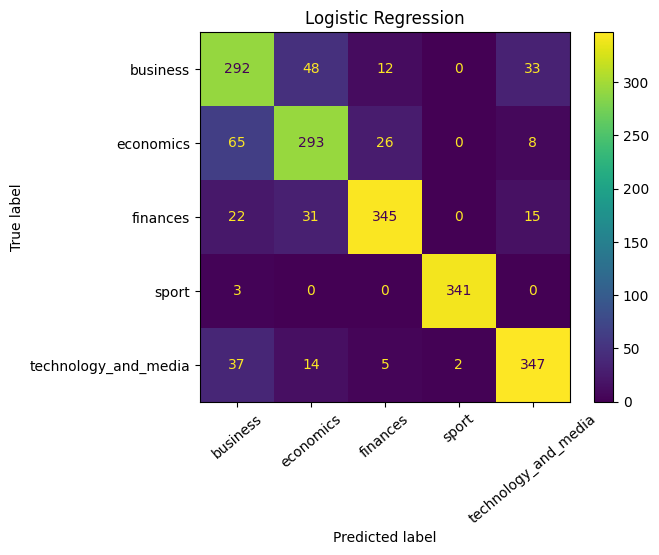

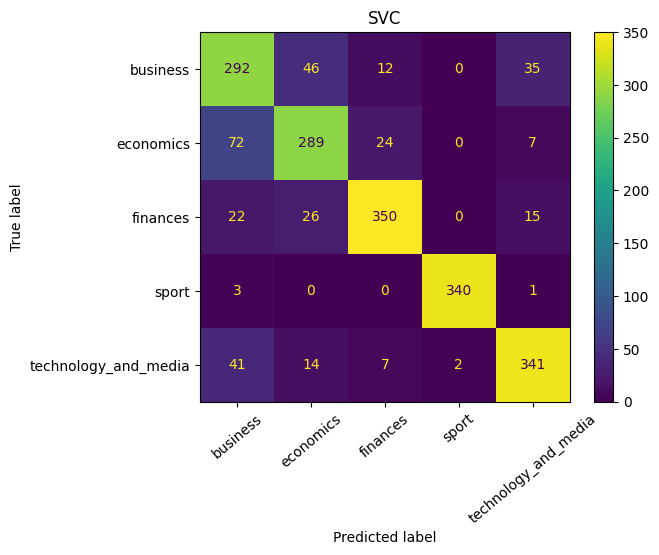

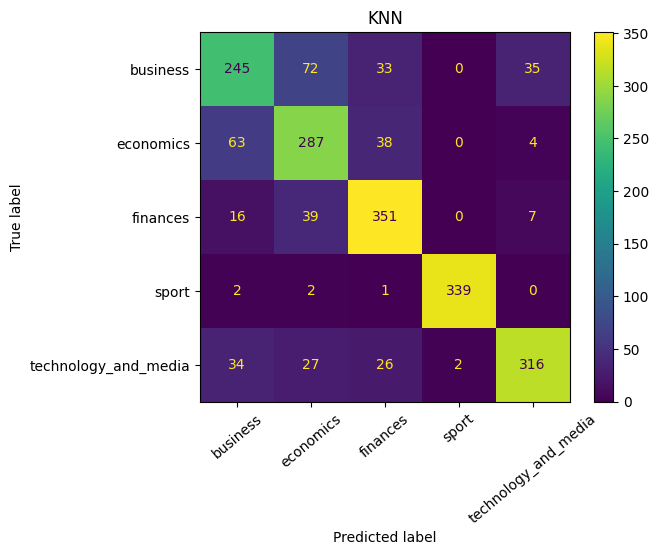

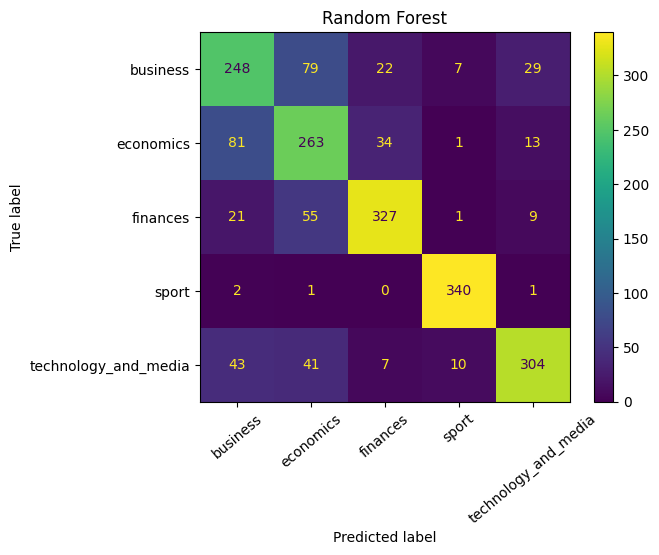

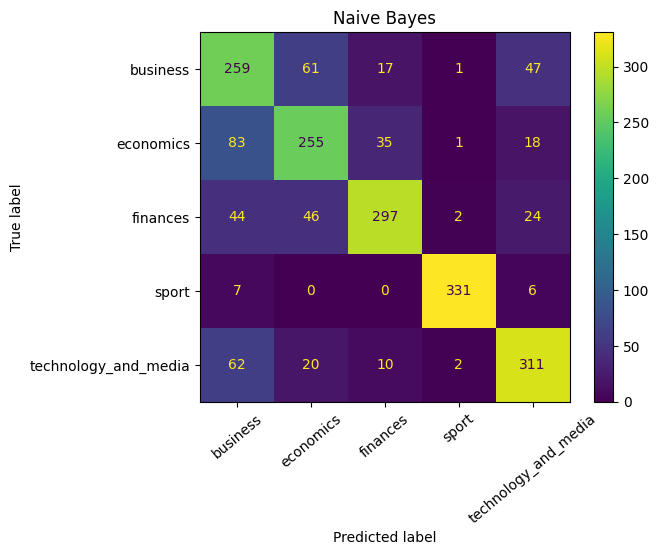

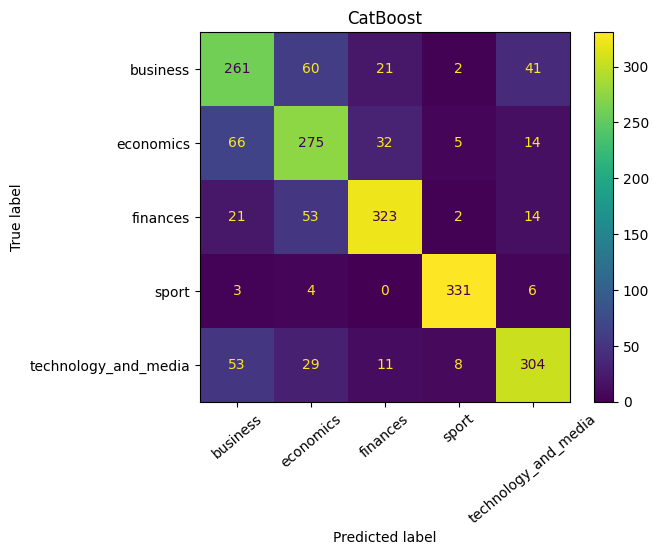

In [114]:
accuracies = []
for name, clf in best_models:
    clf.fit(X_train_tfidf.toarray(), y_train)
    y_pred = clf.predict(X_test_tfidf.toarray())
    accuracies.append(accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['business', 'economics', 'finances', 'sport',
       'technology_and_media'])
    disp.plot()
    plt.xticks(rotation=40)
    plt.title(name)
    plt.show()

В матрицах ошибок моделей видны логичные закономерности: модели чаще путают категории, которые пересекаются между собой, например экономику и бизнес и почти не путают сильно отличающиеся категории, например финансы и спорт.

In [110]:
accuracies

[0.8344507478081485,
 0.8313563692625064,
 0.7931923671995874,
 0.7663744198040227,
 0.7493553378029912,
 0.7705002578648789]

In [126]:
accs_df = pd.DataFrame([accuracies], columns=np.array(best_models)[:, 0])
accs_df = accs_df.rename(index={0: 'accuracy'})
accs_df

,Logistic Regression,SVC,KNN,Random Forest,Naive Bayes,CatBoost
accuracy,0.834451,0.831356,0.793192,0.764312,0.749355,0.7705
